In [2]:
#import

In [3]:
import os
from pyexpat import features

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

In [4]:
#test load

minio = {
        "client_kwargs": {"endpoint_url": "http://localhost:9000"},
        "key": "minio",
        "secret": "minio123"
    }

minio_path =f"s3a://nyc-raw-branch-1/data"


df = pd.read_parquet(minio_path, storage_options=minio)

df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2012-01-01 00:07:56,2012-01-01 00:12:09,1,0.9,1,N,158,231,2,4.9,0.5,0.5,0.00,0.0,0.0,5.90,NaN,NaN
1,1,2012-01-01 00:18:49,2012-01-01 00:30:01,1,2.3,1,N,231,164,2,8.5,0.5,0.5,0.00,0.0,0.0,9.50,NaN,NaN
2,1,2012-01-01 00:31:38,2012-01-01 00:46:05,1,2.2,1,N,164,148,2,9.3,0.5,0.5,0.00,0.0,0.0,10.30,NaN,NaN
3,1,2012-01-01 00:47:35,2012-01-01 00:55:57,4,0.9,1,N,148,107,2,5.3,0.5,0.5,0.00,0.0,0.0,6.30,NaN,NaN
4,1,2012-01-01 00:57:08,2012-01-01 01:02:42,3,0.7,1,N,107,107,2,4.5,0.5,0.5,0.00,0.0,0.0,5.50,NaN,NaN
5,1,2012-01-01 00:47:10,2012-01-01 01:06:18,1,4.7,1,N,226,239,1,14.9,0.5,0.5,2.00,0.0,0.0,17.90,NaN,NaN
6,1,2012-01-01 00:16:42,2012-01-01 00:40:14,1,2.3,1,N,234,237,2,12.9,0.5,0.5,0.00,0.0,0.0,13.90,NaN,NaN
7,1,2012-01-01 00:40:46,2012-01-01 01:03:49,1,2.2,1,N,237,68,1,12.9,0.5,0.5,2.00,0.0,0.0,15.90,NaN,NaN
8,1,2012-01-01 00:10:04,2012-01-01 00:20:54,1,2.4,1,N,161,263,1,8.9,0.5,0.5,2.97,0.0,0.0,12.87,NaN,NaN
9,1,2012-01-01 00:28:10,2012-01-01 00:32:50,1,1.4,1,N,237,236,1,5.3,0.5,0.5,1.89,0.0,0.0,8.19,NaN,NaN


In [5]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [6]:
# Colonne to keep for the train :
"""
vendorid
hour
day((monday,tuesday,wednesday,thursday,friday...)
time
passager count
trip_distance
ratecodeid
location (departure and arrival)

#we don't keep the payement type because it not count the tips with cash ..
"""

"\nvendorid\nhour\nday((monday,tuesday,wednesday,thursday,friday...)\ntime\npassager count\ntrip_distance\nratecodeid\nlocation (departure and arrival)\n\n#we don't keep the payement type because it not count the tips with cash ..\n"

In [7]:
#Clean

df_clean = df[
    (df['trip_distance']> 0) &
    df['trip_distance'].notnull() &
    (df['total_amount']>0) &
    (df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']).dt.total_seconds()>0 &
    (df['DOLocationID']<264) &
    (df['PULocationID']<264)&
(df['fare_amount'] > 2.5) & (df['fare_amount'] < 150) &  # Prix réalistes
    (df['trip_distance'] > 0) & (df['trip_distance'] < 50) & # Distances réalistes
    (df['passenger_count'] > 0) & (df['passenger_count'] < 7) # Nombre de passagers
 ]


print(f"df {len(df)}")
print(f"df_clean {len(df_clean)}")

df 12714444
df_clean 12714444


In [7]:
#Normal i already cleaned it

In [8]:
#Built new dataset
df_clean["hour"] = df_clean['tpep_pickup_datetime'].dt.hour
df_clean["day"] = df_clean['tpep_pickup_datetime'].dt.day_of_week
df_clean["duration"] = (df_clean['tpep_dropoff_datetime']- df_clean['tpep_pickup_datetime']).dt.total_seconds()/60
df_clean["RatecodeID"].unique()
test = df_clean["hour","day","duration","VendorID","PULocationID","DOLocationID","passenger_count","RatecodeID","VendorID","trip_distance"]


KeyError: ('hour', 'day', 'duration', 'VendorID', 'PULocationID', 'DOLocationID', 'passenger_count', 'RatecodeID', 'VendorID', 'trip_distance')

In [ ]:
features = ["hour","day","duration","VendorID","PULocationID","DOLocationID","passenger_count","RatecodeID","trip_distance"]

X = df_clean[features]
print(X.head)
y = df_clean["total_amount"]
print(X.head())
categorical_features = ["PULocationID", "DOLocationID", "RatecodeID", "VendorID", "hour", "day"]

for col in categorical_features:
    df_clean[col] = df_clean[col].astype('category')

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(f"X_train {X_train.shape}")
print(f"T_train {Y_train.shape}")
print(f"X_test {X_test.shape}")
print(f"Y-test {Y_test.shape}")
print("start training")

model = XGBRegressor(n_jobs=-1)

grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6, 8]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train.values, Y_train)


X_train (2400957, 9)
T_train (2400957,)
X_test (600240, 9)
Y-test (600240,)
start training
Fitting 5 folds for each of 12 candidates, totalling 60 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.01, 0.1], 'max_depth': [4, 6, ...], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is d

In [74]:
predictions = grid_search.predict(X_test.values)

rmse = np.sqrt(mean_squared_error(predictions, Y_test))
print(f"result rmse train{(-grid_search.best_score_)**0.5:.4f}")
print(f"result rmse test{np.sqrt(mean_squared_error(Y_test, predictions))}")

print(f"best paramètre : {grid_search.best_params_}")

result rmse train6.6253
result rmse test6.430887909920724
best paramètre : {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


In [77]:
#2nd test
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train, Y_train, test_size=0.10, random_state=42
)
model = XGBRegressor(
    n_jobs=-1,
    tree_method='hist',
    n_estimators=1000,
    early_stopping_rounds=10
)
grid_test= {
    'learning_rate': [0.05, 0.1],
    'max_depth': [8,10,12]
}
grid_search_test = GridSearchCV(
    estimator=model,
    param_grid=grid_test,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=3
)
grid_search_test.fit(
    X_train_final.values,
    Y_train_final,
    eval_set=[(X_val.values, Y_val)], # Le modèle surveille ce set
    verbose=100
)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[0]	validation_0-rmse:21.88818
[100]	validation_0-rmse:6.93302
[200]	validation_0-rmse:6.77765
[289]	validation_0-rmse:6.71535
[CV 1/3] END .learning_rate=0.05, max_depth=8;, score=-43.873 total time= 1.0min
[0]	validation_0-rmse:21.88673
[100]	validation_0-rmse:6.82176
[200]	validation_0-rmse:6.63396
[300]	validation_0-rmse:6.55682
[395]	validation_0-rmse:6.51853
[CV 2/3] END .learning_rate=0.05, max_depth=8;, score=-43.076 total time= 1.5min
[0]	validation_0-rmse:21.89099
[100]	validation_0-rmse:6.78013
[200]	validation_0-rmse:6.57233
[234]	validation_0-rmse:6.55098
[CV 3/3] END .learning_rate=0.05, max_depth=8;, score=-48.008 total time=  41.2s
[0]	validation_0-rmse:21.87002
[100]	validation_0-rmse:6.75602
[200]	validation_0-rmse:6.61328
[300]	validation_0-rmse:6.56037
[320]	validation_0-rmse:6.55823
[CV 1/3] END learning_rate=0.05, max_depth=10;, score=-42.695 total time= 1.2min
[0]	validation_0-rmse:21.87079
[100]	validat

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.05, 0.1], 'max_depth': [8, 10, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score i

In [78]:
predictions_test = grid_search.predict(X_test.values)

rmse = np.sqrt(mean_squared_error(predictions_test, Y_test))
print(f"result rmse train{(-grid_search_test.best_score_)**0.5:.4f}")
print(f"result rmse test{np.sqrt(mean_squared_error(Y_test, predictions_test))}")

print(f"best paramètre : {grid_search_test.best_params_}")

result rmse train6.6471
result rmse test6.430887909920724
best paramètre : {'learning_rate': 0.1, 'max_depth': 8}


In [108]:
print(y)
df_clean['test'] = (df_clean['total_amount'] -df_clean['tip_amount'])
y_notips = (df_clean[['test']])
print(y_notips)
y_tips = df_clean[['tip_amount']]

0          24.94
1          86.14
2          16.45
3          25.85
4          57.54
           ...  
3001192    98.46
3001193    31.50
3001194    53.79
3001195    85.38
3001196    70.26
Name: total_amount, Length: 3001197, dtype: float64
          test
0        19.95
1        86.14
2        16.45
3        24.85
4        47.95
...        ...
3001192  83.44
3001193  26.25
3001194  38.79
3001195  71.44
3001196  58.84

[3001197 rows x 1 columns]


In [109]:
from sklearn.metrics import root_mean_squared_error



X_train, X_test, Y_train, Y_test = train_test_split(X,y_notips, test_size=0.2, random_state=42)

X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train, Y_train, test_size=0.10, random_state=42
)
model = XGBRegressor(
    n_jobs=-1,
    tree_method='hist',
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=8,
    early_stopping_rounds=10,
    enable_categorical = True
)

model.fit(
    X_train_final.values,
    Y_train_final,
    eval_set=[(X_train_final.values, Y_train_final),(X_val.values, Y_val)],
    verbose=100
)

y_pred = model.predict(X_test.values)

rmse = root_mean_squared_error(Y_test, y_pred)
print(f"RMSE: {rmse:.2f}")

mean_fare = Y_test.mean()
print(f"Erreur moyenne (RMSE) : {rmse:.2f}")



[0]	validation_0-rmse:18.40260	validation_1-rmse:18.24363
[100]	validation_0-rmse:3.32477	validation_1-rmse:3.91268
[102]	validation_0-rmse:3.32011	validation_1-rmse:3.91205
RMSE: 3.87
Erreur moyenne (RMSE) : 3.87


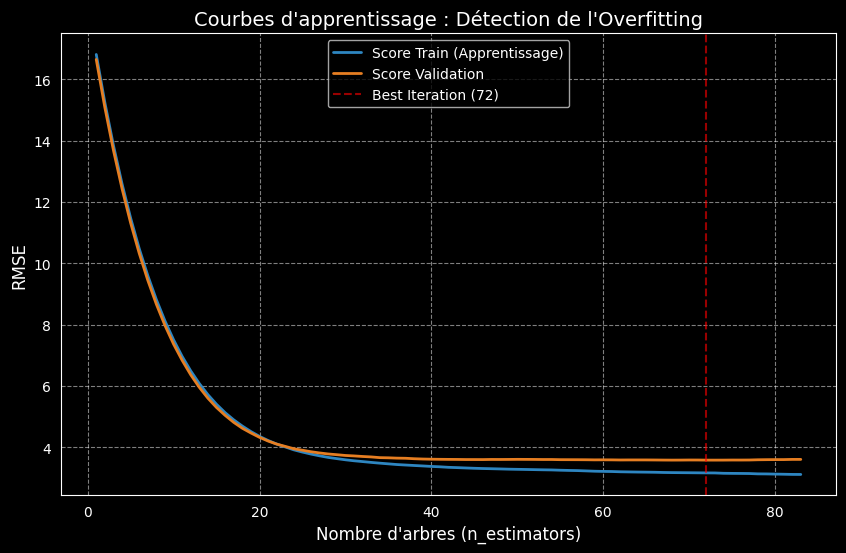

In [102]:
import matplotlib.pyplot as plt
results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epochs = range(1, len(train_rmse) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_rmse, label='Score Train (Apprentissage)', color='#2E86C1', lw=2)
plt.plot(epochs, val_rmse, label='Score Validation', color='#E67E22', lw=2)

best_epoch = model.best_iteration
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.6, label=f'Best Iteration ({best_epoch})')

plt.title('Courbes d\'apprentissage : Détection de l\'Overfitting', fontsize=14)
plt.xlabel('Nombre d\'arbres (n_estimators)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


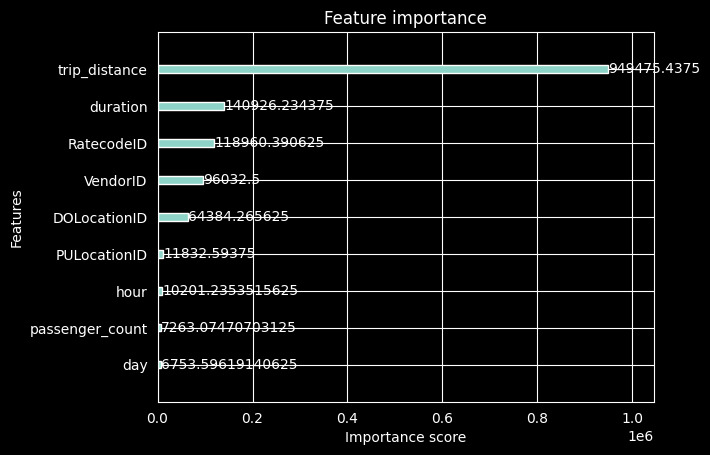

In [111]:
import matplotlib.pyplot as plt
from xgboost import plot_importance


model.get_booster().feature_names = features
plot_importance(model, importance_type='gain')
plt.show()

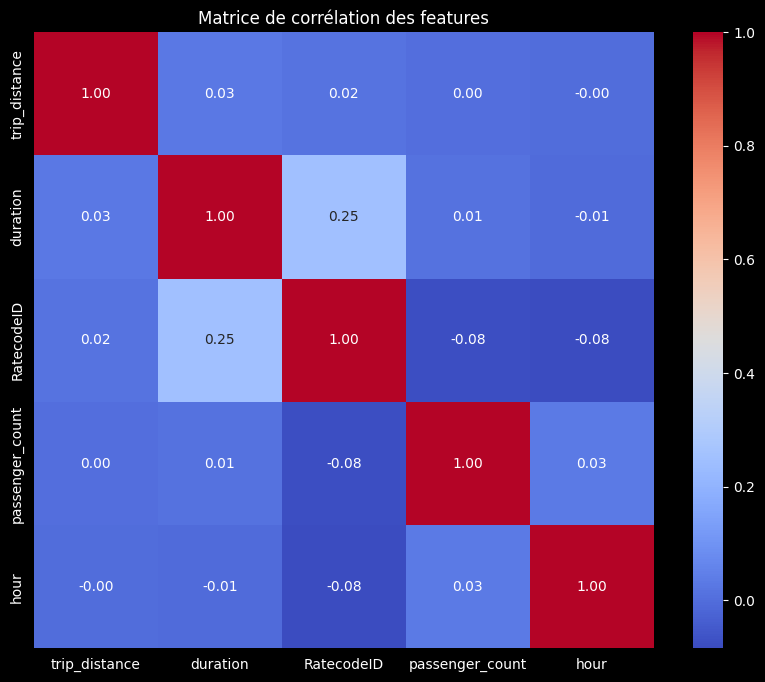

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt


corr = df_clean[['trip_distance', 'duration', 'RatecodeID', 'passenger_count', 'hour']].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des features")
plt.show()

In [9]:
print(df.columns)
print(df[df["VendorID"]==7].count())
print(df[df["RatecodeID"]==1].count())

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64
VendorID                 12487896
tpep_pickup_datetime     12487896
tpep_dropoff_datetime 